#### **Import Libraries**

In [15]:
import jax 
import jax.numpy as jnp
import optax 
import matplotlib.pyplot as plt
from pathlib import Path
from functools import partial 
import os 
import flax 
import numpy as np
from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer
import pickle 
from collections import OrderedDict
from tqdm import tqdm
import pickle
import textwrap

#### **Define Paths**

In [3]:
github_folder = str(Path(os.getcwd()).parent.parent.parent.absolute())
import_np_link = github_folder + f"/evictions/np_data/judicial/prompt_scraped_data_False.npz"
paper_raw = github_folder + "/rtc_paper/figures/" 
print(github_folder)

/Users/ppower1/Documents/GitHub


#### **Setup Plotting**

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-dark-palette')

from matplotlib import font_manager 
locations = github_folder + '/evictions/styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

def format_date(x, pos=None):
    month_year = mdates.num2date(x).strftime('%b\n%Y')
    if  mdates.num2date(x).month == 1:
        return month_year
    else:
        return  mdates.num2date(x).strftime('%b')

/Users/ppower1/Documents/GitHub/evictions/styles/Newsreader
/Users/ppower1/Documents/GitHub/evictions/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-BoldItalic.ttf


/var/folders/3l/12mcyxkx38jdv4zv_hxngvtw0000gn/T/ipykernel_41702/4271427086.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


#### **Parameterize Notebook**

In [5]:
outcome_label = 'legalaid'
num = 0
split_frac = 0.5
with_zip = False
instrument = True 
sims = 50

#### **Read & Organize the Data**

In [6]:
# Load numpy data
loaded_data = np.load(import_np_link, allow_pickle=True)

# Feature Matrix
X = loaded_data['Four_with_zip'] if with_zip else loaded_data['Four'] 
print(f"Original Feature Matrix shape: {X.shape}")
X = X[:, 1:] # Remove the intercept
print(f"New Feature Matrix shape: {X.shape}")

# Target
target = loaded_data[outcome_label]
print(f"Outcome Shape: {target.shape}")
if outcome_label == 'legal_outcome':
    target = (target==num).astype(jnp.float32)
    print(f"Outcome Shape: {target.shape}")

# File Indicator
idx_data = loaded_data['File'] == 1.0

# RTC (Instrument)
Z_orig = loaded_data['treatment']
Z = Z_orig[idx_data]

# Restrict to data with files
X, target = X[idx_data], target[idx_data]
print(f"Data with files --> Features: {X.shape} Target: {target.shape}")

# Sample Weights
raw_sample_weights =  loaded_data['sample_weight'][idx_data]
print(f"Min 'Raw' sample weight: {jnp.min(raw_sample_weights)}, Max 'Raw' sample weight: {jnp.max(raw_sample_weights)}")
normalized_weights = raw_sample_weights / jnp.sum(raw_sample_weights)

# Normalization
min_val = jnp.min(X, axis=0)
max_val = jnp.max(X, axis=0)
X_normalized = (X - min_val) / (max_val - min_val)


if instrument:
    inputs = jnp.hstack([X_normalized, Z])
else:
    inputs = X_normalized

Original Feature Matrix shape: (10851, 30)
New Feature Matrix shape: (10851, 29)
Outcome Shape: (10851, 1)
Data with files --> Features: (9797, 29) Target: (9797, 1)
Min 'Raw' sample weight: 1.0, Max 'Raw' sample weight: 4.461538314819336


#### **Setup**

In [7]:
features = inputs.shape[1] 
outer_epochs = 1000
mlp = MLP([32, 32], jax.nn.relu)
model = Model(mlp, jax.nn.sigmoid)
supervised_loss = Supervised_Loss(binary_cross_entropy, model.embellished_fwd_pass, reg_value=0, aux_status=False)
outer_lr = 0.01
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=outer_lr, momentum=0.9), outer_epochs)

#### **Training**

In [8]:
StandardResults = {}
key = jax.random.PRNGKey(0)
for i in tqdm(range(sims)):

    # Create Keys
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

    # Initialize the parameters
    params = ModelParams.init_fn(subkey1, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(subkey2, inputs.shape[0])

    # Training Indices
    train_idx = idx[:int(split_frac * inputs.shape[0])]
    p_train = normalized_weights[train_idx]/jnp.sum(normalized_weights[train_idx])
    train_idx = jax.random.choice(subkey3, train_idx, shape=(train_idx.shape[0],), p=p_train)

    # Validation Indices
    val_idx = idx[int(split_frac * inputs.shape[0]):]
    p_val = normalized_weights[val_idx]/jnp.sum(normalized_weights[val_idx])
    val_idx = jax.random.choice(subkey4, val_idx, shape=(val_idx.shape[0],), p=p_val)
    is_in_val = jnp.isin(jnp.arange(inputs.shape[0]), val_idx)                                   # Check if the index is in the validation set

    # Train the model
    params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, inputs, target, jnp.ones_like(target), train_idx, val_idx)
    StandardResults[i] = {'params': opt_params, 
                          'train_loss_history': train_loss_history, 
                          'val_loss_history': val_loss_history,
                          'val_idx': is_in_val}

100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


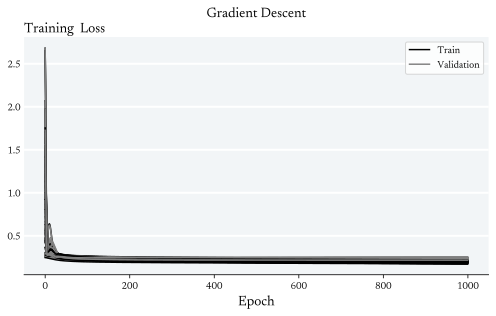

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Gradient Descent', size=14, loc='center', pad=20)

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Training  Loss', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
for i in range(sims):
    if i == 1:
        plt.plot(StandardResults[i]['train_loss_history'], color='black', label='Train')
        plt.plot(StandardResults[i]['val_loss_history'], color='grey', label='Validation')
    else:
        plt.plot(StandardResults[i]['train_loss_history'], color='black')
        plt.plot(StandardResults[i]['val_loss_history'], color='grey')
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()

In [10]:
if instrument:
    r1 = jnp.hstack([model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.ones_like(Z)))) for i in range(sims)])
    r0 = jnp.hstack([model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.zeros_like(Z)))) for i in range(sims)])
    idx = jnp.hstack([StandardResults[i]['val_idx'].reshape(-1,1) for i in range(sims)])
    avg1 = jnp.sum(r1 * idx, axis=1) / jnp.sum(idx, axis=1)
    avg0 = jnp.sum(r0 * idx, axis=1)/ jnp.sum(idx, axis=1)
    print(jnp.mean(avg1 - avg0))

0.1234138


In [11]:
if outcome_label == 'legalaid':
    if instrument:
        np.save(github_folder + f'/evictions/np_data/judicial/nn_legalaid_instrument.npy', avg1-avg0)
        np.save(github_folder + f'/evictions/np_data/judicial/nn_legalaid_instrument_avg1.npy', avg1)
        np.save(github_folder + f'/evictions/np_data/judicial/nn_legalaid_instrument_avg0.npy', avg0)
    else:
        np.save(github_folder + '/evictions/np_data/judicial/nn_legalaid_no_instrument.npy', avg)
else:
    np.save(github_folder + f'/evictions/np_data/judicial/nn_legal_outcome_{num}_instrument.npy', avg1- avg0)


#### **First Stage Effect by Estimated Non-RTC Legal Aid Prob**

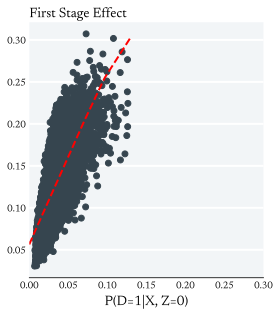

In [38]:
if instrument:

    # Fit Model
    features = 1
    outer_epochs = 1000
    mlp = MLP([32, 32], jax.nn.relu)
    loess_model = Model(mlp, lambda x: x)
    supervised_loss = Supervised_Loss(mse, loess_model.embellished_fwd_pass, reg_value=0, aux_status=False)
    outer_lr = 0.01
    yuri = Trainer(supervised_loss, optax.sgd(learning_rate=outer_lr, momentum=0.9), outer_epochs)
    params = ModelParams.init_fn(jax.random.PRNGKey(0), mlp, features)
    params,_   = yuri.train(params, avg0.reshape(-1,1), (avg1-avg0).reshape(-1,1), jnp.ones_like(avg0).reshape(-1,1))

    fig = plt.figure(dpi=300, tight_layout=True, figsize=(4, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    ax.text(0., 1.02, s='First Stage Effect', transform=ax.transAxes, size=14)
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    plt.scatter(avg0, avg1-avg0, color='#36454F')
    xs = jnp.linspace(0, 0.13, 100)
    plt.plot(xs, loess_model.fwd_pass(params, xs.reshape(-1,1)), color='red', linewidth=2, linestyle='--')
    plt.xlim(0, 0.3)
    plt.xlabel("P(D=1|X, Z=0)", size=14)
    fig.savefig(paper_raw + f"fstage_heterogeneity_{with_zip}_{num}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [69]:
if instrument:
    StandardResults['Estimated_Effect'] = []
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes()
    ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    ax.set_title('The Effect of RTC on Legal Aid Takeup', size=14, loc='center', pad=20)
    ax.text(0., 1.02, s='P(D=1|X, Z=1)', transform=ax.transAxes, size=14)
    ax.yaxis.set_tick_params(length=2)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    value = 0.0
    for k in range(7):
        xs = jnp.linspace(0, 0.27, 100)
        ys = jax.vmap(lambda x: x + value)(xs)
        plt.plot(xs, ys, linestyle='--', linewidth=1, color='grey')
        ax.annotate(f"{value:.2f}", (0.275, 0.275 + value), color='navy', fontsize=8)
        value += 0.05
    ax.annotate("First Stage Effect", (0.25, 0.62), color='black', fontsize=8, weight='bold')

    for i in tqdm(range(5)):
        if instrument:
            Ds1 = model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.ones_like(Z)))) 
            Ds0 =  model.fwd_pass(StandardResults[i]['params'], jnp.hstack((X_normalized, jnp.zeros_like(Z))) )
        else:
            Ds1 =  model.fwd_pass(StandardResults[i]['params'], X_normalized) 
            Ds0 =  model.fwd_pass(StandardResults[i]['params'], X_normalized)
        Estimated_Effect = Ds1 - Ds0
        StandardResults['Estimated_Effect'].append(jnp.dot(Estimated_Effect.reshape(-1,), normalized_weights))
        
        plt.scatter(Ds0, Ds1, s=3, alpha=0.5)

    plt.xlabel("P(D=1|X, Z=0)", size=14)
    plt.ylim(0, 0.65)
    plt.xlim(0, 0.3)
    fig.savefig(paper_raw + f"standard_training_{outcome_label}_{with_zip}_{num}.png", dpi=300, bbox_inches='tight')
    plt.show()

100%|██████████| 5/5 [00:00<00:00, 71.50it/s]


In [12]:
if not instrument:
    d1 = np.load(github_folder + f'/evictions/np_data/judicial/nn_legalaid_instrument_avg1.npy').reshape(-1,1)
    d0 = np.load(github_folder + f'/evictions/np_data/judicial/nn_legalaid_instrument_avg0.npy').reshape(-1,1)
    dx = np.load(github_folder + f'/evictions/np_data/judicial/nn_legalaid_no_instrument.npy').reshape(-1,1)
    dxz = Z* d1 + (1-Z) * d0
    nn_iv_resid = dxz - dx 
    np.save(github_folder + f'/evictions/np_data/judicial/nn_iv_resid.npy', nn_iv_resid)
    plt.hist((dxz - dx).reshape(-1,), bins=100)
    plt.show()

    
    